## Summative Coursework - Experiments Investigating PRSH 

In [42]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random
import pandas as pd
import importlib
import scipy.stats as sp

import BSE
importlib.reload(BSE) # important to ensure most recent version of BSE used 
from BSE import market_session, set_PRSH_parameters

# graphing functions from BSE Intro Practical 


# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_transactions.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks, title):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    plt.title(title)
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode, title):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks, title) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

### Analysing How Changes In k Affect Behaviour
#### Market Conditions
I choose to emulate market conditions used by Vytelingum and Cliff/Snashall, inspired by Smith as these are well-documented experimental conditions believed to be varied enough to make strong claims about the ability of algorithms.

I also take inspiration from IBMs experiments, testing both balanced-group and one-to-many trader sets.

To change the k parameter I have written an extra function in BSE that sets a global variable to the k value.

In [134]:
# Experimental setup
dir = r'C:\Users\Joest\OneDrive\Documents\Actual Docs\Bristol\ITFT\ITFT-Coursework-Assessment\market_outputs\\'

trials_per_k = 50 # important for valid results as PRSH is stochastic 

balanced_sellers_spec = [("ZIP", 5),("ZIC", 5),("PRSH", 5), ("SHVR", 5), ("GVWY", 5)]
balanced_buyers_spec = balanced_sellers_spec
balanced_traders_spec = {"sellers":balanced_sellers_spec, "buyers":balanced_buyers_spec}

start_time = 0
end_time = 3000 # needs to be long to allow for different strats to be tried

max_k = 10
min_k = 2

def csv_prep(fname, total_traders):
    dir = r'C:\Users\Joest\OneDrive\Documents\Actual Docs\Bristol\ITFT\ITFT-Coursework-Assessment\market_outputs\\'
    tdump = open(dir + fname, 'w')

    # annotate columns
    tdump.write('%s, %s,%s,%s, ' % ('expid', 'time','best bid','best offer')) 
    for f in range(total_traders):
            tdump.write('%s, %s, %s, %s, ' % ('type', 'balance', 'number of traders', 'profit per trader'))
    tdump.write('%s, %s, ' % ('best bid','best offer'))
    tdump.write('\n');
    return tdump



In [135]:
## M1 experiment - symmetric supply/demand, range (10, 50), fixed stepmode, drip jitter order interval

# CSV preparation

fname = 'balanced_market_output_m1.csv'
tdump = csv_prep(fname, total_traders = 6)

sup_range = (10, 50)
dem_range = sup_range

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = supply_schedule

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

trial = 0
k_iteration = 0
for k in range(min_k, max_k):
        k_iteration += 1
        set_PRSH_parameters(k)
        while trial < k_iteration * trials_per_k:
                market_session(trial, start_time, end_time, balanced_traders_spec, order_sched, tdump, False, True)
                tdump.flush()
                trial = trial + 1


0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  

25;  

26;  

27;  

28;  

29;  

30;  

31;  

32;  

33;  

34;  

35;  

36;  

37;  

38;  

39;  

40;  

41;  

42;  

43;  

44;  

45;  

46;  

47;  

48;  

49;  

50;  

51;  

52;  

53;  

54;  

55;  

56;  

57;  

58;  

59;  

60;  

61;  

62;  

63;  

64;  

65;  

66;  

67;  

68;  

69;  

70;  

71;  

72;  

73;  

74;  

75;  

76;  

77;  

78;  

79;  

80;  

81;  

82;  

83;  

84;  

85;  

86;  

87;  

88;  

89;  

90;  

91;  

92;  

93;  

94;  

95;  

96;  

97;  

98;  

99;  

100;  

101;  

102;  

103;  

104;  

105;  

106;  

107;  

108;  

109;  

110;  

111;  

112;  

113;  

114;  

115;  

116;  

117;  

118;  

119;  

120;  

121;  

122;  

123;  

124;  

125;  

126;  

127;  

128;  

129;  

130;  

131;  

132;  

133;  

134;  

135;  

136;  

137;  

138; 

In [136]:
## M2 experiment - symmetric supply/demand, range (10, 50), fixed stepmode, drip jitter order interval
# CSV preparation

fname = 'balanced_market_output_m2.csv'
tdump = csv_prep(fname, total_traders = 6)

sup_range = (10, 50)
dem_range = (25, 35)

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = [{'from':start_time, 'to':end_time, "ranges":[dem_range], "stepmode":"fixed"}]

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

trial = 0
k_iteration = 0 
for k in range(min_k, max_k):
        k_iteration += 1
        set_PRSH_parameters(k)
        while trial < k_iteration * trials_per_k:
                market_session(trial, start_time, end_time, balanced_traders_spec, order_sched, tdump, False, True)
                tdump.flush()
                trial = trial + 1


0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  

25;  

26;  

27;  

28;  

29;  

30;  

31;  

32;  

33;  

34;  

35;  

36;  

37;  

38;  

39;  

40;  

41;  

42;  

43;  

44;  

45;  

46;  

47;  

48;  

49;  

50;  

51;  

52;  

53;  

54;  

55;  

56;  

57;  

58;  

59;  

60;  

61;  

62;  

63;  

64;  

65;  

66;  

67;  

68;  

69;  

70;  

71;  

72;  

73;  

74;  

75;  

76;  

77;  

78;  

79;  

80;  

81;  

82;  

83;  

84;  

85;  

86;  

87;  

88;  

89;  

90;  

91;  

92;  

93;  

94;  

95;  

96;  

97;  

98;  

99;  

100;  

101;  

102;  

103;  

104;  

105;  

106;  

107;  

108;  

109;  

110;  

111;  

112;  

113;  

114;  

115;  

116;  

117;  

118;  

119;  

120;  

121;  

122;  

123;  

124;  

125;  

126;  

127;  

128;  

129;  

130;  

131;  

132;  

133;  

134;  

135;  

136;  

137;  

138; 

In [137]:
# MS14 experiment
# CSV preparation

fname = 'balanced_market_output_ms14.csv'
tdump = csv_prep(fname, total_traders = 6)

sup_range = (10, 50)
dem_range = (10, 50)
sup_range_shock = (20, 60)
dem_range_shock = (20, 60)

mid_time = end_time/2

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = [{'from':start_time, 'to':end_time, "ranges":[dem_range], "stepmode":"fixed"}]

supply_schedule = [{'from':start_time, 'to':mid_time, "ranges":[sup_range], "stepmode":"fixed"}, {'from':mid_time, 'to':end_time, "ranges":[sup_range_shock], "stepmode":"fixed"}]
demand_schedule = [{'from':start_time, 'to':mid_time, "ranges":[dem_range], "stepmode":"fixed"}, {'from':mid_time, 'to':end_time, "ranges":[dem_range_shock], "stepmode":"fixed"}]

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

trial = 0
k_iteration = 0 
for k in range(min_k, max_k):
        k_iteration += 1
        set_PRSH_parameters(k)
        while trial < k_iteration * trials_per_k:
                market_session(trial, start_time, end_time, balanced_traders_spec, order_sched, tdump, False, True)
                tdump.flush()
                trial = trial + 1


0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  

25;  

26;  

27;  

28;  

29;  

30;  

31;  

32;  

33;  

34;  

35;  

36;  

37;  

38;  

39;  

40;  

41;  

42;  

43;  

44;  

45;  

46;  

47;  

48;  

49;  

50;  

51;  

52;  

53;  

54;  

55;  

56;  

57;  

58;  

59;  

60;  

61;  

62;  

63;  

64;  

65;  

66;  

67;  

68;  

69;  

70;  

71;  

72;  

73;  

74;  

75;  

76;  

77;  

78;  

79;  

80;  

81;  

82;  

83;  

84;  

85;  

86;  

87;  

88;  

89;  

90;  

91;  

92;  

93;  

94;  

95;  

96;  

97;  

98;  

99;  

100;  

101;  

102;  

103;  

104;  

105;  

106;  

107;  

108;  

109;  

110;  

111;  

112;  

113;  

114;  

115;  

116;  

117;  

118;  

119;  

120;  

121;  

122;  

123;  

124;  

125;  

126;  

127;  

128;  

129;  

130;  

131;  

132;  

133;  

134;  

135;  

136;  

137;  

138; 

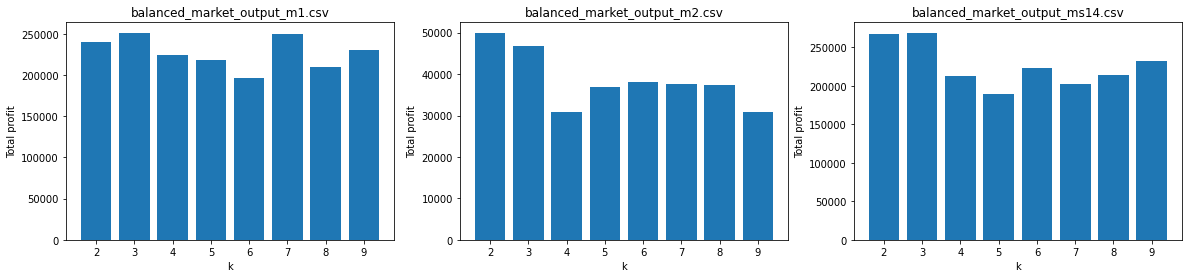

In [138]:
## Visualising
csvs = ['balanced_market_output_m1.csv', 'balanced_market_output_m2.csv', 'balanced_market_output_ms14.csv']

fig, axs = plt.subplots(figsize=(20,4), nrows=1, ncols=3)

cumulative_profit = np.zeros(8) 
cumulative_df = pd.DataFrame()

target = zip(csvs, axs.flatten())
for (csv1, ax) in target:
    i = 0 # index for cumulative profit

    trades_df = pd.read_csv(dir+csv1)
    #trades_df = trades_df.assign(k = np.repeat(np.arange(min_k, max_k + 1), trials_per_k))

    # Just PRSH performance, grouped by k values
    PRSH_df = trades_df.iloc[:,8:10]
    PRSH_df = PRSH_df.assign(k = np.repeat(np.arange(min_k, max_k ), trials_per_k))
    cumulative_df = pd.concat([cumulative_df, PRSH_df])
    groups = PRSH_df.groupby(pd.Grouper(key='k')).sum()
    
    for key in groups:
        ax.bar(groups.get(key).index.to_numpy(), groups.get(key).values)
        ax.set_title(csv1)
        ax.set_ylabel("Total profit")
        ax.set_xlabel("k")
        cumulative_profit += groups.get(key).values
        i += 1
        
plt.show()

Text(0, 0.5, 'Profit')

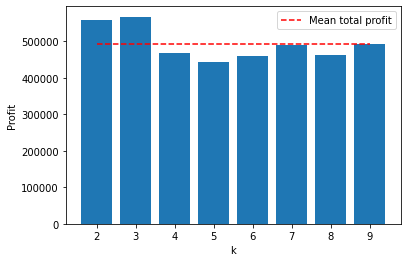

In [139]:
## Summed profit
fig = plt.figure()
ax = plt.subplot(111)

mean_profit = np.mean(cumulative_profit)

ax.bar(np.arange(2,10), cumulative_profit)
ax.plot(np.arange(2,10), [mean_profit] * 8, linestyle='--', label = "Mean total profit", color = 'red')
ax.legend()

plt.xlabel('k')
plt.ylabel('Profit')

In [140]:
### Statistical Testing
### Using Wilcoxon Test (as not independent), want to know if one k is significantly better then another/the rest
### Setting significance level at 0.05 for all tests

k1 = 3
k2 = 4

k1_balances = cumulative_df[cumulative_df['k'] == k1].iloc[:, 1]
k2_balances = cumulative_df[cumulative_df['k'] == k2].iloc[:, 1]

print("p value: " + sp.wilcoxon(k1_balances, k2_balances, alternative="greater")[1].astype('str'))

p value: 0.005506174256959422


In [141]:
## ANOVA - two or more groups have the same population mean
## Assumes independence and from normally distributed pop with equal sd
k_balances = []
for k in range (2, 10):
    k_balances.append(cumulative_df[cumulative_df['k'] == k].iloc[:, 1])

print(sp.f_oneway(*k_balances))

## Alexander-Govern - does not assume equal sd

print(sp.alexandergovern(*k_balances))

## Kruskal-Wallis - assumes chi squared distribution

print(sp.kruskal(*k_balances))


F_onewayResult(statistic=1.8071120549484756, pvalue=0.08221447681972399)
AlexanderGovernResult(statistic=12.1004497948648, pvalue=0.097303537658125)
KruskalResult(statistic=11.182748528094411, pvalue=0.13084388368096986)


Results suggest that varying k does not significantly effect profits under any of the statistical assumptions.

In [142]:
# Pairwise comparison against ZIP, M1 conditions changing ratios, ks

for i in range(min_k, max_k):
    fname = 'pairwise_output_m1_' + str(i) + '.csv'
    tdump = csv_prep(fname, total_traders = 2)

    set_PRSH_parameters(k)

    total_traders = 5
    trials_per_ratio = 50
    trial = 0

    for j in range (1, total_traders):
        sellers_spec = [("ZIP", j), ("PRSH", total_traders - j)]
        buyers_spec = sellers_spec
        traders_spec = {"sellers": sellers_spec, "buyers": buyers_spec}

        sup_range = (10, 50)
        dem_range = sup_range

        supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
        demand_schedule = supply_schedule

        order_interval = 10
        order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}
        
        while trial <  j * trials_per_ratio:
                market_session(trial, start_time, end_time, traders_spec, order_sched, tdump, False, True)
                tdump.flush()
                trial += 1



0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  

25;  

26;  

27;  

28;  

29;  

30;  

31;  

32;  

33;  

34;  

35;  

36;  

37;  

38;  

39;  

40;  

41;  

42;  

43;  

44;  

45;  

46;  

47;  

48;  

49;  

50;  

51;  

52;  

53;  

54;  

55;  

56;  

57;  

58;  

59;  

60;  

61;  

62;  

63;  

64;  

65;  

66;  

67;  

68;  

69;  

70;  

71;  

72;  

73;  

74;  

75;  

76;  

77;  

78;  

79;  

80;  

81;  

82;  

83;  

84;  

85;  

86;  

87;  

88;  

89;  

90;  

91;  

92;  

93;  

94;  

95;  

96;  

97;  

98;  

99;  

100;  

101;  

102;  

103;  

104;  

105;  

106;  

107;  

108;  

109;  

110;  

111;  

112;  

113;  

114;  

115;  

116;  

117;  

118;  

119;  

120;  

121;  

122;  

123;  

124;  

125;  

126;  

127;  

128;  

129;  

130;  

131;  

132;  

133;  

134;  

135;  

136;  

137;  

138; 

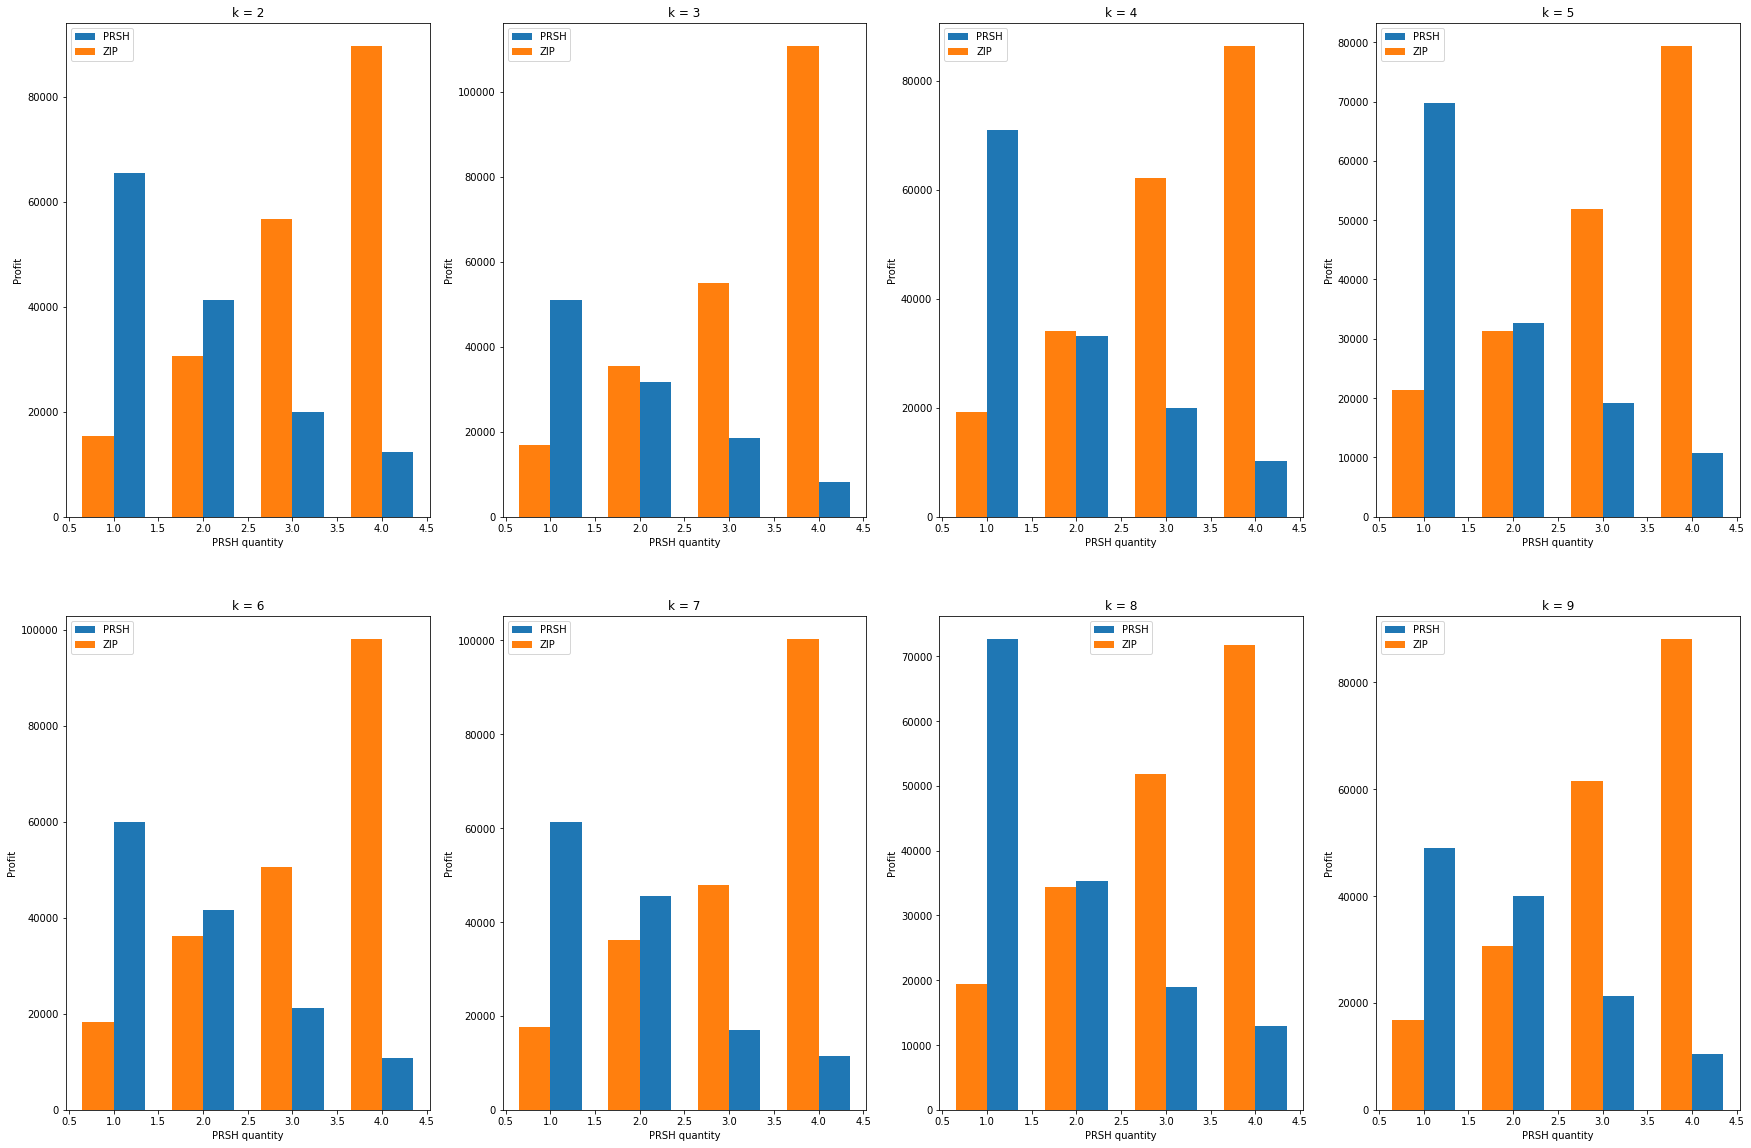

In [143]:
# Visualising profit per trader as trader number varies

fig, axs = plt.subplots(2,4,figsize=(30,20))

for i, ax in zip(range (min_k, max_k), axs.ravel()):
    trades_df = pd.read_csv(dir + 'pairwise_output_m1_' + str(i) + '.csv')
    trades_df.columns = trades_df.columns.str.strip()

    trades_df = trades_df.loc[:,['profit per trader', 'number of traders', 'profit per trader.1']]

    groups = trades_df.groupby(pd.Grouper(key='number of traders')).sum()

    label1 = "PRSH"
    width = 0.35
    
    for key in groups:

        ax.bar(groups.get(key).index.to_numpy()/2 + width/2, groups.get(key).values, np.abs(width), label = label1)
        ax.set_title("k = " + str(i))
        ax.set_xlabel("PRSH quantity")
        ax.set_ylabel("Profit")
        width = -width
        label1 = "ZIP"
        ax.legend()
plt.show()

Observations:

Appears ZIP always better on average.

Seem k makes little difference, same patterns on display, mostly relating to ratio changes.

PRSH seems to do better when there are fewer PRSH traders, but really badly when there are fewer ZIP.

In [145]:
## Statistical testing
## Wilcoxon as it is a pairwise test that does not assume independence
## Test whether each PRSH is better than ZIP

for k in range (2, 10):
    trades_df = pd.read_csv(dir + 'pairwise_output_m1_' + str(k) + '.csv')

    ZIP_balances = trades_df.iloc[:, 11]
    PRSH_balances = trades_df.iloc[:, 7]
    
    print("k = " + str(k))
    print(sp.wilcoxon(PRSH_balances, ZIP_balances, alternative="greater"))

k = 2
WilcoxonResult(statistic=7615.0, pvalue=0.9985163965068943)
k = 3
WilcoxonResult(statistic=5069.0, pvalue=0.9999999993902994)
k = 4
WilcoxonResult(statistic=7054.0, pvalue=0.9998717255455916)
k = 5
WilcoxonResult(statistic=7277.0, pvalue=0.9996422046553609)
k = 6
WilcoxonResult(statistic=7192.5, pvalue=0.9997554328567325)
k = 7
WilcoxonResult(statistic=7113.0, pvalue=0.999830581894414)
k = 8
WilcoxonResult(statistic=7494.5, pvalue=0.9990900379671762)
k = 9
WilcoxonResult(statistic=6060.5, pvalue=0.9999994359672743)


No significant results that suggest any ks can make PRSH outperform ZIP

### Analysing How Changing the Mutation Function Affects Behaviour For Set k

Choosing optimal k found in the previous step.
Then try a less optimal k to see if performance can be made on par with the optimal k - relationship between mutation function and k?

Different mutation functions:
- fixed step
- uniform steps
- uniform where half increase/half decrease
- gradient descent inspired? step in direction of most improvement 

Uniform rather than Gaussian means less likely to stay near current s

In [9]:
def default(s, k):
    sdev = 0.05
    newstrat = s
    while newstrat == s:
        newstrat = s + random.gauss(0.0, sdev)  # 
        newstrat = max(-1.0, min(1.0, newstrat)) # clipping to within correct range
    return newstrat
    
def fixed_step_mutate(s, k):
    step_size = 0.1
    # random direction
    dir = random.choice([True, False])
    if dir: return min(1.0, s + step_size)
    else: return max(-1, s - step_size)
    
def uniform_step_mutate(s, k):
    lower = -0.1
    upper = 0.1
    newstrat = s
    while newstrat == s:
        newstrat = s + random.uniform(lower, upper)  # uniform instead of Gaussian 
        newstrat = max(-1.0, min(1.0, newstrat)) # clipping to within correct range
    return newstrat

def uniform_halves(s, k):
    upper = 0.1
    newstrat = s
    while newstrat == s:
        if s > k / 2: return min(1, s + random.uniform(0, upper))
        else: return max(-1, s - random.uniform(0, upper))

def uniform_small_big(s, k):
    small_up = 0.05
    big_up = 0.15

    newstrat = s
    while newstrat == s:
        if s > k / 2: return  max(-1.0, min(1.0, s + random.uniform(-small_up, small_up) ))
        else: return  max(-1.0, min(1.0, s + random.uniform(-big_up, big_up)))
    


In [146]:
# Comparing each in m1 conditions

## M1 experiment - symmetric supply/demand, range (10, 50), fixed stepmode, drip jitter order interval

# CSV preparation

fname = 'mutate_balanced_m1.csv'
tdump = open(dir + fname, 'w')

# annotate columns
tdump.write('%s, %s,%s,%s, ' % ('expid', 'time','best bid','best offer')) 
for f in range(6):
        tdump.write('%s, %s, %s, %s, ' % ('type', 'balance', 'number of traders', 'profit per trader'))
tdump.write('%s, %s, ' % ('best bid','best offer'))
tdump.write('\n');


mutate_funcs = [default, fixed_step_mutate, uniform_step_mutate, uniform_halves, uniform_small_big]

sup_range = (10, 50)
dem_range = sup_range

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = supply_schedule

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

trial = 0
trials_per_mutate = 50
func_no = 0

for func in mutate_funcs:
        func_no += 1
        set_PRSH_parameters(k1 = 3, mutate1 = func) # k = 3 was a high scoring k from earlier
        while trial < func_no * trials_per_mutate:
                market_session(trial, start_time, end_time, balanced_traders_spec, order_sched, tdump, False, True)
                tdump.flush()
                trial = trial + 1





0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  

25;  

26;  

27;  

28;  

29;  

30;  

31;  

32;  

33;  

34;  

35;  

36;  

37;  

38;  

39;  

40;  

41;  

42;  

43;  

44;  

45;  

46;  

47;  

48;  

49;  

50;  

51;  

52;  

53;  

54;  

55;  

56;  

57;  

58;  

59;  

60;  

61;  

62;  

63;  

64;  

65;  

66;  

67;  

68;  

69;  

70;  

71;  

72;  

73;  

74;  

75;  

76;  

77;  

78;  

79;  

80;  

81;  

82;  

83;  

84;  

85;  

86;  

87;  

88;  

89;  

90;  

91;  

92;  

93;  

94;  

95;  

96;  

97;  

98;  

99;  

100;  

101;  

102;  

103;  

104;  

105;  

106;  

107;  

108;  

109;  

110;  

111;  

112;  

113;  

114;  

115;  

116;  

117;  

118;  

119;  

120;  

121;  

122;  

123;  

124;  

125;  

126;  

127;  

128;  

129;  

130;  

131;  

132;  

133;  

134;  

135;  

136;  

137;  

138; 

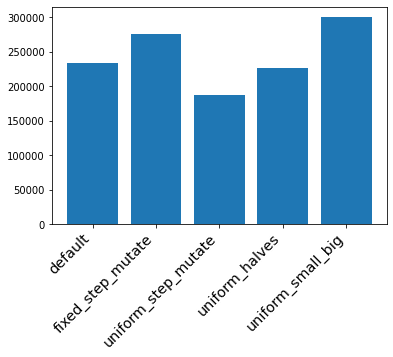

In [147]:
## Visualising
csv1 = 'mutate_balanced_m1.csv'

trades_df = pd.read_csv(dir + csv1)

# Just PRSH performance, grouped by k values
PRSH_df = trades_df.iloc[:,8:10]
PRSH_df = PRSH_df.assign(mutate = np.repeat(['default', 'fixed_step_mutate', 'uniform_step_mutate', 'uniform_halves', 'uniform_small_big'], trials_per_mutate))
groups = PRSH_df.groupby(pd.Grouper(key='mutate')).sum()

for key in groups:
    plt.bar(groups.get(key).index.to_numpy(), groups.get(key).values)
    
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

plt.show()


In [148]:
# different k:
# Comparing each in m1 conditions

## M1 experiment - symmetric supply/demand, range (10, 50), fixed stepmode, drip jitter order interval

# CSV preparation

dir = r'C:\Users\Joest\OneDrive\Documents\Actual Docs\Bristol\ITFT\ITFT-Coursework-Assessment\market_outputs\\'
fname = 'mutate_balanced_m1_k6.csv'
tdump = open(dir + fname, 'w')

# annotate columns
tdump.write('%s, %s,%s,%s, ' % ('expid', 'time','best bid','best offer')) 
for f in range(6):
        tdump.write('%s, %s, %s, %s, ' % ('type', 'balance', 'number of traders', 'profit per trader'))
tdump.write('%s, %s, ' % ('best bid','best offer'))
tdump.write('\n');


mutate_funcs = [default, fixed_step_mutate, uniform_step_mutate, uniform_halves, uniform_small_big]

sup_range = (10, 50)
dem_range = sup_range

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = supply_schedule

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}

trial = 0
trials_per_mutate = 50
func_no = 0

for func in mutate_funcs:
        func_no += 1
        set_PRSH_parameters(k1 = 6, mutate1 = func)
        while trial < func_no * trials_per_mutate:
                market_session(trial, start_time, end_time, balanced_traders_spec, order_sched, tdump, False, True)
                tdump.flush()
                trial = trial + 1


0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  

25;  

26;  

27;  

28;  

29;  

30;  

31;  

32;  

33;  

34;  

35;  

36;  

37;  

38;  

39;  

40;  

41;  

42;  

43;  

44;  

45;  

46;  

47;  

48;  

49;  

50;  

51;  

52;  

53;  

54;  

55;  

56;  

57;  

58;  

59;  

60;  

61;  

62;  

63;  

64;  

65;  

66;  

67;  

68;  

69;  

70;  

71;  

72;  

73;  

74;  

75;  

76;  

77;  

78;  

79;  

80;  

81;  

82;  

83;  

84;  

85;  

86;  

87;  

88;  

89;  

90;  

91;  

92;  

93;  

94;  

95;  

96;  

97;  

98;  

99;  

100;  

101;  

102;  

103;  

104;  

105;  

106;  

107;  

108;  

109;  

110;  

111;  

112;  

113;  

114;  

115;  

116;  

117;  

118;  

119;  

120;  

121;  

122;  

123;  

124;  

125;  

126;  

127;  

128;  

129;  

130;  

131;  

132;  

133;  

134;  

135;  

136;  

137;  

138; 

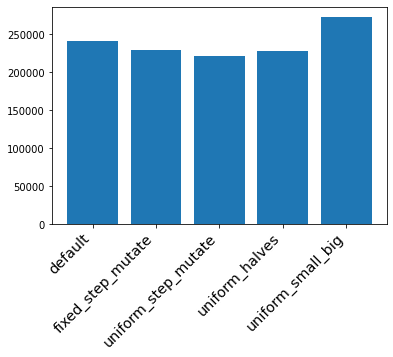

In [149]:
## Visualising
dir = r'C:\Users\Joest\OneDrive\Documents\Actual Docs\Bristol\ITFT\ITFT-Coursework-Assessment\market_outputs\\'
csv1 = 'mutate_balanced_m1_k6.csv'

trades_df = pd.read_csv(dir + csv1)

# Just PRSH performance, grouped by k values
PRSH_df = trades_df.iloc[:,8:10]
PRSH_df = PRSH_df.assign(mutate = np.repeat(['default', 'fixed_step_mutate', 'uniform_step_mutate', 'uniform_halves', 'uniform_small_big'], trials_per_mutate))
groups = PRSH_df.groupby(pd.Grouper(key='mutate')).sum()

for key in groups:
    plt.bar(groups.get(key).index.to_numpy(), groups.get(key).values)
    
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

plt.show()

In [150]:
# Different market
# ms14

fname = 'mutate_balanced_ms14.csv'
tdump = open(dir + fname, 'w')

# annotate columns
tdump.write('%s, %s,%s,%s, ' % ('expid', 'time','best bid','best offer')) 
for f in range(6):
        tdump.write('%s, %s, %s, %s, ' % ('type', 'balance', 'number of traders', 'profit per trader'))
tdump.write('%s, %s, ' % ('best bid','best offer'))
tdump.write('\n');


mutate_funcs = [default, fixed_step_mutate, uniform_step_mutate, uniform_halves, uniform_small_big]

sup_range = (10, 50)
dem_range = (10, 50)
sup_range_shock = (20, 60)
dem_range_shock = (20, 60)

mid_time = end_time/2

supply_schedule = [{'from':start_time, 'to':end_time, "ranges":[sup_range], "stepmode":"fixed"}]
demand_schedule = [{'from':start_time, 'to':end_time, "ranges":[dem_range], "stepmode":"fixed"}]

supply_schedule = [{'from':start_time, 'to':mid_time, "ranges":[sup_range], "stepmode":"fixed"}, {'from':mid_time, 'to':end_time, "ranges":[sup_range_shock], "stepmode":"fixed"}]
demand_schedule = [{'from':start_time, 'to':mid_time, "ranges":[dem_range], "stepmode":"fixed"}, {'from':mid_time, 'to':end_time, "ranges":[dem_range_shock], "stepmode":"fixed"}]

order_interval = 10
order_sched = {"sup":supply_schedule, "dem":demand_schedule, "interval":order_interval,"timemode":"drip-jitter"}
trial = 0
trials_per_mutate = 50
func_no = 0

for func in mutate_funcs:
        func_no += 1
        set_PRSH_parameters(k1 = 3, mutate1 = func)
        while trial < func_no * trials_per_mutate:
                market_session(trial, start_time, end_time, balanced_traders_spec, order_sched, tdump, False, True)
                tdump.flush()
                trial = trial + 1





0;  

1;  

2;  

3;  

4;  

5;  

6;  

7;  

8;  

9;  

10;  

11;  

12;  

13;  

14;  

15;  

16;  

17;  

18;  

19;  

20;  

21;  

22;  

23;  

24;  

25;  

26;  

27;  

28;  

29;  

30;  

31;  

32;  

33;  

34;  

35;  

36;  

37;  

38;  

39;  

40;  

41;  

42;  

43;  

44;  

45;  

46;  

47;  

48;  

49;  

50;  

51;  

52;  

53;  

54;  

55;  

56;  

57;  

58;  

59;  

60;  

61;  

62;  

63;  

64;  

65;  

66;  

67;  

68;  

69;  

70;  

71;  

72;  

73;  

74;  

75;  

76;  

77;  

78;  

79;  

80;  

81;  

82;  

83;  

84;  

85;  

86;  

87;  

88;  

89;  

90;  

91;  

92;  

93;  

94;  

95;  

96;  

97;  

98;  

99;  

100;  

101;  

102;  

103;  

104;  

105;  

106;  

107;  

108;  

109;  

110;  

111;  

112;  

113;  

114;  

115;  

116;  

117;  

118;  

119;  

120;  

121;  

122;  

123;  

124;  

125;  

126;  

127;  

128;  

129;  

130;  

131;  

132;  

133;  

134;  

135;  

136;  

137;  

138; 

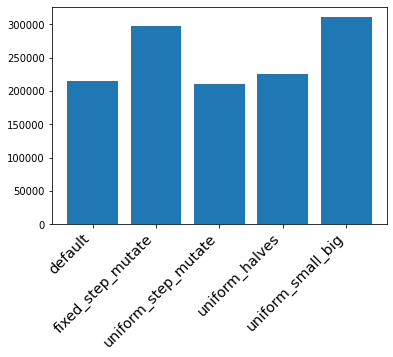

In [151]:
## Visualising
csv1 = 'mutate_balanced_ms14.csv'

trades_df = pd.read_csv(dir + csv1)

# Just PRSH performance, grouped by k values
PRSH_df = trades_df.iloc[:,8:10]
PRSH_df = PRSH_df.assign(mutate = np.repeat(['default', 'fixed_step_mutate', 'uniform_step_mutate', 'uniform_halves', 'uniform_small_big'], trials_per_mutate))
groups = PRSH_df.groupby(pd.Grouper(key='mutate')).sum()

for key in groups:
    plt.bar(groups.get(key).index.to_numpy(), groups.get(key).values)
    
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

Text(0, 0.5, 'Profit')

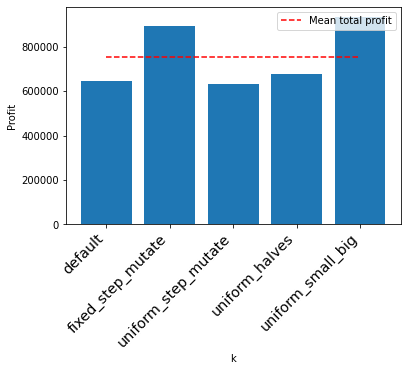

In [152]:
# Summing results of all the experiments to assess performance:
cumulative_profit = np.zeros(5) 
cumulative_df = pd.DataFrame()

csvs = ['mutate_balanced_m1.csv', 'mutate_balanced_m1_k6.csv', 'mutate_balanced_ms14.csv']
for c in csvs:
    trades_df = pd.read_csv(dir + csv1)
    PRSH_df = trades_df.iloc[:,8:10]
    PRSH_df = PRSH_df.assign(mutate = np.repeat(['default', 'fixed_step_mutate', 'uniform_step_mutate', 'uniform_halves', 'uniform_small_big'], trials_per_mutate))
    groups = PRSH_df.groupby(pd.Grouper(key='mutate')).sum()
    cumulative_df = pd.concat([cumulative_df, PRSH_df])
    cumulative_profit += groups.get(key).values

fig = plt.figure()
ax = plt.subplot(111)

mean_profit = np.mean(cumulative_profit)

ax.bar(['default', 'fixed_step_mutate', 'uniform_step_mutate', 'uniform_halves', 'uniform_small_big'], cumulative_profit)
ax.plot(['default', 'fixed_step_mutate', 'uniform_step_mutate', 'uniform_halves', 'uniform_small_big'], [mean_profit] * 5, linestyle='--', label = "Mean total profit", color = 'red')
ax.legend()    

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

plt.xlabel('k')
plt.ylabel('Profit')


This would suggest that checking half smaller and half bigger changes is the best strat, while checking half increase and half decrease is not always better. Statistical testing:

In [153]:
## ANOVA - two or more groups have the same population mean
## Assumes independence and from normally distributed pop with equal sd
k_balances = []
mutates = ['default', 'fixed_step_mutate', 'uniform_step_mutate', 'uniform_halves', 'uniform_small_big'] 
for s in mutates:
    k_balances.append(cumulative_df[cumulative_df['mutate'] == s].iloc[:, 1])

print(sp.f_oneway(*k_balances))

## Alexander-Govern - does not assume equal sd

print(sp.alexandergovern(*k_balances))

## Kruskal-Wallis - assumes chi squared distribution

print(sp.kruskal(*k_balances))

F_onewayResult(statistic=15.199423393450378, pvalue=5.929122219503541e-12)
AlexanderGovernResult(statistic=55.76022571841003, pvalue=2.2512292167938047e-11)
KruskalResult(statistic=57.76942459323152, pvalue=8.53056737495239e-12)


In [154]:
default_balances = cumulative_df[cumulative_df['mutate'] == 'default'].iloc[:, 1]

for s in ['fixed_step_mutate', 'uniform_step_mutate', 'uniform_halves', 'uniform_small_big'] :
    new_balances = cumulative_df[cumulative_df['mutate'] == s].iloc[:, 1]
    
    print("Mutate strat = " + s)
    print(sp.wilcoxon(new_balances, default_balances, alternative="greater"))

Mutate strat = fixed_step_mutate
WilcoxonResult(statistic=8103.0, pvalue=2.3341908582537606e-06)
Mutate strat = uniform_step_mutate
WilcoxonResult(statistic=5478.0, pvalue=0.6353968104179386)
Mutate strat = uniform_halves
WilcoxonResult(statistic=6633.0, pvalue=0.034305667229938754)
Mutate strat = uniform_small_big
WilcoxonResult(statistic=8304.0, pvalue=3.5923260603852036e-07)


### Analysing an Adapted PRSH Trader

In [ ]:
# import improved PRSH from separate file
# analyse how changing parameters affect it in similar way to above?
# compare optimised parameter EPRSH and PRSH in each market to compare performance?